
#**LABORATORIO 1 TIC 1**

Integrantes:


*   Cristián Astorga González.
*   Ailine Morales Álvarez.



### **Introducción**
El objetivo del informe es realizar un análisis inferencial correspondiente a la base de datos "Categorización de salarios en los campos de la ciencia de datos" con el fin de analizar los salarios dependiendo del puesto y la experiencia. Dentro de los objetivos específicos del análisis se encuentra:

*  Estudiar las áreas más comunes dentro del campo de la ciencia de datos. 

*  Estudiar las diferencias salariales entre las áreas más comunes.

*  Estudiar si la experiencia influye en el salario.
   
link: https://www.kaggle.com/datasets/whenamancodes/data-science-fields-salary-categorization

## **Carga de datos, preprocesamiento, medidas estadísticas y visualizaciones**

### **Carga de datos mediante google drive.**




In [1]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/MyDrive/minorencienciadedatos

/content/gdrive/MyDrive/minorencienciadedatos


### **Librerías**

In [3]:
#Se importan los módulos pandas, numpy y matplotlib
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from prompt_toolkit.shortcuts.utils import print_container
from scipy.stats import ttest_ind,shapiro
from numpy import unique,where
from sklearn.datasets import make_classification
from sklearn.cluster import AgglomerativeClustering,KMeans,OPTICS,DBSCAN
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score, DistanceMetric
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree,model_selection, ensemble, preprocessing, feature_selection,linear_model, metrics, decomposition, naive_bayes, neighbors
from sklearn.preprocessing import KBinsDiscretizer
from functools import wraps
import time
from datetime import datetime
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

### **Funciones**

In [4]:
def check_variance_homogeneity(group1,group2):
  """
 Testea si la varianza entre dos grupos de datos es la misma e imprime una conclusión
  """
  test_stat_var,p_value_var = stats.levene(group1,group2)
  print("p value:%.4f" % p_value_var)
  if p_value_var < 0.05:
    print("Se rechaza la hipótesis nula >> Las varianzas de las muestras son diferentes.")
  else:
    print("No se puede rechazar la hipótesis nula >> Las varianzas de las muestras son las mismas")


In [5]:
def check_normality(data):
  """ 
  Test que comprueba la normalidad de una muestra menor a 50 datos.
  """
  test_stat_normality, p_value_normality=stats.shapiro(data)
  print("p value:%.4f" % p_value_normality)
  if p_value_normality <0.05:
    print("Se rechaza la hipótesis nula >> La data no está normalmente distribuida")
  else:
    print("No se puede rechazar la hipótesis nula >> La data está normalmente distribuida")   

In [6]:
for i in range(1,2,1):
  print(i)

1


In [7]:
def Ttest(data1,data2,numero_muestras,tamaño_muestras,alpha = 0.05,una_cola =False):
  """
  Realiza uno o varios T-test entre dos grupos de datos dependiendo del numero de muestras, 
  además testea la normalidad de cada muestra y si las varianzas son iguales entre los datos.
  Entrega los resultados en listas ordenados por el numero de experimento
  """
  NormalX = []
  NormalY = []
  VarXY = []
  Resultados = []
  for i in range(1,numero_muestras+1,1):
    if tamaño_muestras != False:
      X = data1.sample(tamaño_muestras)
      Y = data2.sample(tamaño_muestras)
    else:
      X=data1
      Y=data2
    stat, p = ttest_ind(X, Y)
    if una_cola == True:
      p=p/2
    if p < 0.05:
      Resultados.append('se Rechaza la Hipótesis Nula')
    else:
      Resultados.append('NO se Rechaza la Hipótesis Nula')
    stat, pvalueX = shapiro(X)
    if pvalueX > alpha:
      NormalX.append('Gaussiano')
    else:
      NormalX.append('NO Gaussiano')
    stat, pvalueY = shapiro(Y)
    if pvalueY > alpha:
      NormalY.append('Gaussiano')
    else:
      NormalY.append('NO Gaussiano')
    test_stat_var,p_value_var = stats.levene(X,Y)
    if p_value_var < 0.05:
      VarXY.append(f'Las Varianzas son DIFERENTES en la muestra {i}')
    else:
      VarXY.append(f'Las Varianzas son IGUALES en la muestra {i}')
  print(NormalX)
  print(NormalY)
  print(VarXY)
  print(Resultados)

In [8]:
def evaluate_clusters(scores,  preds, labels, name='', X=None):

    if X is not None:

        silhouette = silhouette_score(X, preds, metric='euclidean')
        cal_har = calinski_harabasz_score(X, preds)
        dav_bould = davies_bouldin_score(X, preds)

        adj_mut_info = adjusted_mutual_info_score(labels, preds, average_method='arithmetic')
        adj_rand = adjusted_rand_score(labels, preds)

        content = {'Algorithm':name,
                   'Silhouette':silhouette,
                   'Calinski_Harabasz':cal_har,
                   'Davis Bouldin':dav_bould,
                   'Adjusted_Mutual_Info':adj_mut_info,
                   'Adjusted_Rand_Score':adj_rand}

        scores = scores.append(content, ignore_index = True)

    else:

        adj_mut_info = adjusted_mutual_info_score(labels, preds, average_method='arithmetic')
        adj_rand = adjusted_rand_score(labels, preds)

        content = {'Algorithm':name,
                   'Silhouette':np.NaN,
                   'Calinski_Harabasz':np.NaN,
                   'Davis Bouldin':np.NaN,
                   'Adjusted_Mutual_Info':adj_mut_info,
                   'Adjusted_Rand_Score':adj_rand}

        scores = scores.append(content, ignore_index = True)
    return scores

In [9]:
def comparacion_graficos1(x,y):
  print('Cantidad de elementos por cluster con el algoritmo',x,':')
  print(df1[y].value_counts())
  plt.figure(figsize = (5,5))
  sns.set(style='whitegrid')
  sns.boxplot(x =y, y ='Monthly_Salary_In_Millclp',
               data = df1)
  sns.factorplot(y,data=pd.concat([df1.iloc[:,0:4],df1[y]],axis=1),kind="count",aspect =1)
  plt.xlabel('Clusters')
  plt.ylabel('Cantidad')

In [10]:
def comparacion_graficos(x,y):
  print('Cantidad de elementos por cluster con el algoritmo',x,':')
  print(df1[y].value_counts())
  plt.figure(figsize = (5,5))
  sns.set(style='whitegrid')
  sns.boxplot(x =y, y ='Monthly_Salary_In_Millclp',
               data = df1)
  sns.factorplot(y,data=pd.concat([df1.iloc[:,9:11],df1[y]],axis=1),kind="count",aspect =1)
  plt.xlabel('Clusters')
  plt.ylabel('Cantidad')

In [11]:
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'[{datetime.now()}] Function {func.__name__} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper


In [12]:
@timeit
def randomized_search(model, param_dic):
    """
    Busca de manera random un modelo con los mejores parametros
    Al ser random, no hace toda la combinatoria posible
    :parameter
        :param model: model
        :param param_dic: parametros para busqueda aleatoria
    :return
        :modelo resultante
    """
    
    dic_scores = {'accuracy':metrics.make_scorer(metrics.accuracy_score), 'precision':metrics.make_scorer(metrics.precision_score), 
                      'recall':metrics.make_scorer(metrics.recall_score), 'f1':metrics.make_scorer(metrics.f1_score)}
    grid_search = model_selection.RandomizedSearchCV(model, param_dic, scoring=dic_scores, refit='f1').fit(X_train, y_train)
    print("Best Model parameters:", grid_search.best_params_)
    print("Best Model mean "+'f1'+":", round(grid_search.best_score_, 2))
    model = grid_search.best_estimator_
    
    return model

@timeit
def grid_search(model, param_dic):
    """
    Busca de manera exhaustiva mediante grilla un modelo con los mejores parametros
    :parameter
        :param model: model
        :param param_dic: parametros para grilla
    :return
        :modelo resultante
    """
    
    dic_scores = {'accuracy':metrics.make_scorer(metrics.accuracy_score), 'precision':metrics.make_scorer(metrics.precision_score), 
                      'recall':metrics.make_scorer(metrics.recall_score), 'f1':metrics.make_scorer(metrics.f1_score)}
    grid_search = model_selection.GridSearchCV(model, param_dic, scoring=dic_scores, refit='f1').fit(X_train, y_train)
    print("Best Model parameters:", grid_search.best_params_)
    print("Best Model mean "+'f1'+":", round(grid_search.best_score_, 2))
    model = grid_search.best_estimator_
    
    return model

In [13]:
"""
Evalua el performance de un modelo
:parameter
    :param y_test: array
    :param predicted: array
    :param predicted_prob: array
    :param show_thresholds: bool - si es verdadero muestra el threshold en los gráficos
"""
def evaluate_classif_model(y_test, predicted, predicted_prob, show_thresholds=True, figsize=(25,5)):
    classes = np.unique(y_test)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    ## Accuray e AUC
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print("Auc:", round(auc,2))
    
    ## Precision e Recall
    recall = metrics.recall_score(y_test, predicted)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_test, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_test, predicted,average='weighted')  #=2 * (precision * recall) / (precision + recall)
    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
    print("F1 score:", round(f1,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in classes]))
       
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', ax=ax[0], cmap=plt.cm.Blues, cbar=False)
    ax[0].set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax[0].set_yticklabels(labels=classes, rotation=0)
 
    ## Plot roc
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob)    
    ax[1].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(fpr, tpr))
    ax[1].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[1].hlines(y=recall, xmin=-0.05, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[1].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
    ax[1].set(xlim=[-0.05,1], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")     
    ax[1].legend(loc="lower right")
    ax[1].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[1].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]), textcoords='offset points', ha='left', va='bottom')
                thres_in_plot.append(t)
    
    ## Plot precision-recall curve
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob)
    ax[2].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(recalls, precisions))
    ax[2].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
    ax[2].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[2].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
    ax[2].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[2].legend(loc="lower left")
    ax[2].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[2].annotate(np.round(t,1), xy=(recalls[i],precisions[i]), xytext=(recalls[i],precisions[i]), textcoords='offset points', ha='right', va='bottom')
                thres_in_plot.append(t)

    plt.show()

In [14]:
def Escalamiento_min_max(df,columna):
  df[columna] = (df[columna] - df[columna].min()) / (df[columna].max() - df[columna].min())

In [15]:
def seleccion_caracteristicas(modelo):
  from sklearn.inspection import permutation_importance
  #calculate permutation importance for test data 
  result_test = permutation_importance(
      modelo, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
      )
  sorted_importances_idx_test = result_test.importances_mean.argsort()
  importances_test = pd.DataFrame(
      result_test.importances[sorted_importances_idx_test].T,
      columns=X.columns[sorted_importances_idx_test],
      )
  #calculate permutation importance for training data 
  result_train = permutation_importance(
      modelo, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
      )
  sorted_importances_idx_train = result_train.importances_mean.argsort()
  importances_train = pd.DataFrame(
      result_train.importances[sorted_importances_idx_train].T,
      columns=X.columns[sorted_importances_idx_train],
      )
  f, axs = plt.subplots(1,2,figsize=(15,5))
  importances_test.plot.box(vert=False, whis=10, ax = axs[0])
  axs[0].set_title("Permutation Importances (test set)")
  axs[0].axvline(x=0, color="k", linestyle="--")
  axs[0].set_xlabel("Decrease in accuracy score")
  axs[0].figure.tight_layout()
  
  importances_train.plot.box(vert=False, whis=10, ax = axs[1])
  axs[1].set_title("Permutation Importances (train set)")
  axs[1].axvline(x=0, color="k", linestyle="--")
  axs[1].set_xlabel("Decrease in accuracy score")
  axs[1].figure.tight_layout()

In [16]:
def validacion_cruzada(modelo):
  resultados = cross_val_score(modelo, X, Y, cv = 10)
  print(resultados)
  print(resultados.mean())

In [17]:
def accuracy(y_true, y_pred):
    
    """
    Function to calculate accuracy
    -> param y_true: list of true values
    -> param y_pred: list of predicted values
    -> return: accuracy score
    
    """
    
    # Variable de inicialización para almacenar el recuento de clases predichas correctamente
    correct_predictions = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == yp:
            
            correct_predictions += 1
    
    #returns accuracy
    return correct_predictions / len(y_true)

In [18]:
def precision(y_true, y_pred):


    # find the number of classes 
    num_classes = len(np.unique(y_true))
    
    # initialize tp and fp to 0
    tp = 0
    fp = 0
    
    # loop over all classes
    for class_ in y_true.unique():
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        # calculate true positive for current class
        # and update overall tp
        tp += true_positive(temp_true, temp_pred)
        
        # calculate false positive for current class
        # and update overall tp
        fp += false_positive(temp_true, temp_pred)
        
    # calculate and return overall precision
    precision = tp / (tp + fp)
    return precision

In [19]:
def true_positive(y_true, y_pred):
    
    tp = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 1 and yp == 1:
            tp += 1
    
    return tp

def true_negative(y_true, y_pred):
    
    tn = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 0:
            tn += 1
            
    return tn

def false_positive(y_true, y_pred):
    
    fp = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 1:
            fp += 1
            
    return fp

def false_negative(y_true, y_pred):
    
    fn = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 1 and yp == 0:
            fn += 1
            
    return fn

In [20]:
#Computation of macro-averaged recall

def recall(y_true, y_pred):

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize recall to 0
    recall = 0
    
    # loop over all classes
    for class_ in list(y_true.unique()):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        
        
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        
        # keep adding recall for all classes
        recall += temp_recall
        
    # calculate and return average recall over all classes
    recall /= num_classes
    
    return recall

In [21]:
def f1(y_true, y_pred):

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize f1 to 0
    f1 = 0
    
    # loop over all classes
    for class_ in list(y_true.unique()):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        
        
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        
        
        temp_f1 = 2 * temp_precision * temp_recall / (temp_precision + temp_recall + 1e-6)
        
        # keep adding f1 score for all classes
        f1 += temp_f1
        
    # calculate and return average f1 score over all classes
    f1 /= num_classes
    
    return f1

In [22]:
def metricas(modelo,X_test, y_test):
  y_pred = modelo.predict(X_test)
  print(f"accuracy score : {accuracy(y_test, y_pred)}")
  print(f"Precision score : {precision(y_test, y_pred)}")
  print(f"recall score : {recall(y_test, y_pred)}")  
  print(f"f1 score : {f1(y_test, y_pred)}")
  return

In [23]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [24]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [25]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [26]:
def ROC_AUC(modelo,df2_test):
  X_test = df2_test.drop(columns='Y')
  y_test = np.array(df2_test["Y"])
  classes = modelo.classes_
  y_proba = modelo.predict_proba(X_test)
  # Plots the Probability Distributions and the ROC Curves One vs Rest
  plt.figure(figsize = (12, 8))
  bins = [i/20 for i in range(20)] + [1]
  roc_auc_ovr = {}

  for i in range(len(classes)):
      # Gets the class
      c = classes[i]
    
      # Prepares an auxiliar dataframe to help with the plots
      df_aux = X_test.copy()
      df_aux['class'] = [1 if y == c else 0 for y in y_test]
      df_aux['prob'] = y_proba[:, i]
      df_aux = df_aux.reset_index(drop = True)
    
      # Plots the probability distribution for the class and the rest
      ax = plt.subplot(2, 4, i+1)
      sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
      ax.set_title(c)
      ax.legend([f"Class: {c}", "Rest"])
      ax.set_xlabel(f"P(x = {c})")
    
      # Calculates the ROC Coordinates and plots the ROC Curves
      ax_bottom = plt.subplot(2, 4, i+ 5)
      tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
      plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
      ax_bottom.set_title("ROC Curve OvR")
    
      # Calculates the ROC AUC OvR
      roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
  plt.tight_layout()
  return

**Objetivo de la base de datos y variables**

####El objetivo principal de esta base de datos es tener datos que puedan brindar una mejor orientación con respecto a lo que se paga a nivel mundial en el campo de la ciencia de datos. De esta manera, los novatos, los profesionales experimentados, los gerentes de contratación, los reclutadores y también los fundadores de nuevas empresas o las personas que desean cambiar de carrera pueden tomar decisiones mejor informadas.

#### **VARIABLES**

1. ***Working_Year:*** El año en que se pagó el salario.
2. ***Designation*** Rol desempeñado durante el año.
3. ***Experience:*** El nivel de experiencia en el puesto durante el año con los siguientes valores posibles
> **EN** Entry-level / Júnior\
> **MI** Mid-level  / Intermedio\
> **SE** Senior-level / Experto\
> **EX** Executive-level / Director.

4. ***Employment_Status:*** El tipo de empleo para el puesto
> **PT** part-time\
> **FT** full-time\
> **CT** Contrato\
> **FL** freelance.

5. ***Salary_In_Rupees:*** Cantidad de salario en Rupias(moneda de la india).
6. ***Employee_Location:*** El país de residencia principal del empleado durante el año laboral como código de país ISO 3166.

7. ***Company_Location:*** El país de la oficina principal del empleador o sucursal contratante como un código de país ISO 3166.

8. ***Company_Size:*** Número promedio de personas que trabajaron para la empresa durante el año:
> **S** menos de 50 empleados (pequeño)\
> **M** 50 a 250 empleados (medio)\
> **L** más de 250 empleados (grande).

9. 	***Remote_Working_Ratio:*** La cantidad total de trabajo realizado de forma remota, los valores posibles son los siguientes:
> **0** Sin trabajo remoto (menos del 20%)\
> **50** Parcialmente remoto\
> **100** Totalmente remoto (más del 80%).

### **Primera exploración del Dataframe**

In [27]:
df=pd.read_csv("Data_Science_Fields_Salary_Categorization.csv")
df

,Unnamed: 0,Working_Year,Designation,Experience,Employment_Status,Salary_In_Rupees,Employee_Location,Company_Location,Company_Size,Remote_Working_Ratio
0,1,2020,Data Scientist,MI,FT,"6,352,272.00",DE,DE,L,0
1,2,2020,Machine Learning Scientist,SE,FT,"20,688,070.00",JP,JP,S,0
2,3,2020,Big Data Engineer,SE,FT,"8,674,985.00",GB,GB,M,50
3,4,2020,Product Data Analyst,MI,FT,"1,591,390.00",HN,HN,S,0
4,5,2020,Machine Learning Engineer,SE,FT,"11,935,425.00",US,US,L,50
...,...,...,...,...,...,...,...,...,...,...
602,603,2022,Data Engineer,SE,FT,"12,253,703.00",US,US,M,100
603,604,2022,Data Engineer,SE,FT,"10,025,757.00",US,US,M,100
604,605,2022,Data Analyst,SE,FT,"10,264,466.00",US,US,M,0
605,606,2022,Data Analyst,SE,FT,"11,935,425.00",US,US,M,100


In [28]:
#Se elimina la primera columna pues no tiene significancia.
df = df.drop(["Unnamed: 0"],axis = 1)

In [29]:
#Se cambia la moneda utilizada de Rupias a Millones de Clp para poder analizar mejor las cantidades de dinero.
# tipo de cambio al 24/09/2022 
df['Salary_In_Rupees'] = df['Salary_In_Rupees'].str.replace(',', '')
df['Salary_In_Rupees'] = pd.to_numeric(df['Salary_In_Rupees'])
df['Monthly_Salary_In_Millclp'] = (df['Salary_In_Rupees']*11.7/1000000)/12

In [30]:
df = df.drop(["Salary_In_Rupees"],axis =  1)
df

,Working_Year,Designation,Experience,Employment_Status,Employee_Location,Company_Location,Company_Size,Remote_Working_Ratio,Monthly_Salary_In_Millclp
0,2020,Data Scientist,MI,FT,DE,DE,L,0,6.193465
1,2020,Machine Learning Scientist,SE,FT,JP,JP,S,0,20.170868
2,2020,Big Data Engineer,SE,FT,GB,GB,M,50,8.458110
3,2020,Product Data Analyst,MI,FT,HN,HN,S,0,1.551605
4,2020,Machine Learning Engineer,SE,FT,US,US,L,50,11.637039
...,...,...,...,...,...,...,...,...,...
602,2022,Data Engineer,SE,FT,US,US,M,100,11.947360
603,2022,Data Engineer,SE,FT,US,US,M,100,9.775113
604,2022,Data Analyst,SE,FT,US,US,M,0,10.007854
605,2022,Data Analyst,SE,FT,US,US,M,100,11.637039


####**TIPO DE DATOS**

In [31]:
df.dtypes

Working_Year                   int64
Designation                   object
Experience                    object
Employment_Status             object
Employee_Location             object
Company_Location              object
Company_Size                  object
Remote_Working_Ratio           int64
Monthly_Salary_In_Millclp    float64
dtype: object

Podemos ver que hay 3 variables numéricas:
 Remote_Working_Ratio, Monthly_Salary_In_Millclp y Working_Year.

Las demás variables son categóricas.


Dado que la única variable numérica que no categoriza por año o distancia es Monthly_Salary_In_Millclp entonces será la única a la que le realizaremos un describe() para ver sus estadísticas. 

In [32]:
df['Monthly_Salary_In_Millclp'].describe()

count    607.000000
mean       8.712098
std        5.504883
min        0.221802
25%        4.866299
50%        7.879827
75%       11.637039
max       46.548158
Name: Monthly_Salary_In_Millclp, dtype: float64


* El promedio de los salarios entre todos las designaciones es 8.7 millones de pesos mensuales.

* La desviación estandar es 5.5 millones de pesos mensuales.

###**Valores atípicos, datos nulos u observaciones faltantes**

In [33]:
#Revisamos si hay valores 0 en las columnas pues es atípico en todas excepto en Remote_Working_Ratio.
for col in df:
    valores_0 = df[df[col]== 0].shape[0]
    print(f"valores 0 para {col}: {valores_0}")

valores 0 para Working_Year: 0
valores 0 para Designation: 0
valores 0 para Experience: 0
valores 0 para Employment_Status: 0
valores 0 para Employee_Location: 0
valores 0 para Company_Location: 0
valores 0 para Company_Size: 0
valores 0 para Remote_Working_Ratio: 127
valores 0 para Monthly_Salary_In_Millclp: 0


In [34]:
#Datos nulos
df.isnull().sum()

Working_Year                 0
Designation                  0
Experience                   0
Employment_Status            0
Employee_Location            0
Company_Location             0
Company_Size                 0
Remote_Working_Ratio         0
Monthly_Salary_In_Millclp    0
dtype: int64

Notemos que no hay datos nulos en ninguna columna.




####**Dado que nos interesa la columna 'Designation' analizaremos los valores atípicos que aparecen en ella:**

In [35]:
df['Designation'].value_counts()

Data Scientist                              143
Data Engineer                               132
Data Analyst                                 97
Machine Learning Engineer                    41
Research Scientist                           16
Data Science Manager                         12
Data Architect                               11
Big Data Engineer                             8
Machine Learning Scientist                    8
Principal Data Scientist                      7
AI Scientist                                  7
Data Science Consultant                       7
Director of Data Science                      7
Data Analytics Manager                        7
ML Engineer                                   6
Computer Vision Engineer                      6
BI Data Analyst                               6
Lead Data Engineer                            6
Data Engineering Manager                      5
Business Data Analyst                         5
Head of Data                            

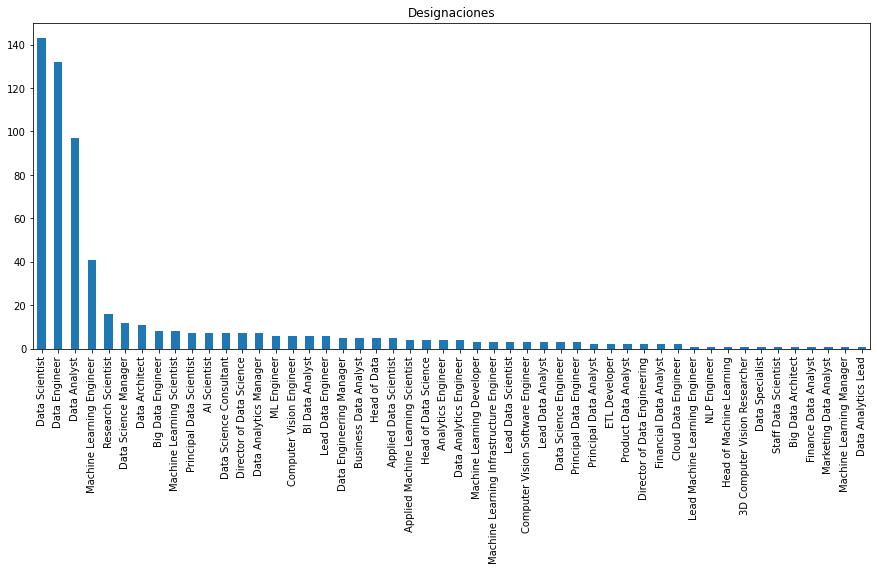

In [36]:
plt.figure(figsize=(15,6))
plot = df['Designation'].value_counts().plot(kind='bar',
                                            title='Designaciones',
                                             linewidth=0.7)

* En este gráfico podemos observar **claramente** que la mayoría de las asignaciones se concentran en las primeras cuatro barras de un total de 50.

***Dado lo anterior como hay muchas asignaciones distintas pero que están relacionadas entre sí (e.j: Director of Data Science y Data Scientist) solo dejaremos los cuatro cargos con más datos (Data Scientist, Data Engineer,Data Analyst y Machine Learning Engineer) y las otras las asignaremos guiándonos mediante el siguiente esquema:***

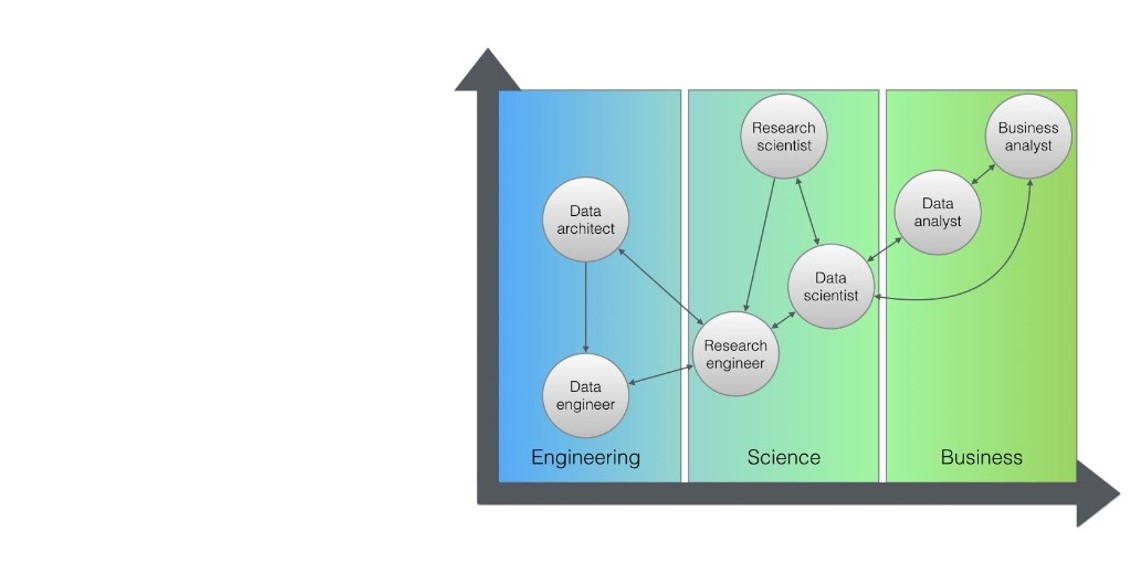

* *En caso de no entrar en ninguna categoría del gráfico se eliminarán (e.g: Computer Vision Engineer).*

* *También se eliminarán si son cargos de alta responsabilidad para no insesgar el salario (e.j: 'Principal Data Analyst').*

In [37]:
Ocupación = {'Data Scientist':'Data Scientist',
'Machine Learning Engineer': 'Machine Learning Engineer',
'Data Engineer' : 'Data Engineer',
'Data Analyst': 'Data Analyst',
'Research Scientist' : 'Data Scientist', #16
'Data Science Manager': np.nan, #12
'Data Architect':'Data Engineer', #11
'Big Data Engineer': np.nan, #8
'Machine Learning Scientist': np.nan, #8
'Principal Data Scientist': np.nan, #7
'AI Scientist': np.nan, #7
'Data Science Consultant':np.nan, #7
'Director of Data Science': np.nan, #7
'Data Analytics Manager':np.nan,  #7
'ML Engineer': 'Machine Learning Engineer', #6
'Computer Vision Engineer': np.nan, #6
'BI Data Analyst': np.nan ,  #6
'Lead Data Engineer': np.nan,#6
'Data Engineering Manager': np.nan,  #5
'Business Data Analyst':'Data Analyst',  #5
'Head of Data': np.nan, #5
'Applied Data Scientist': 'Data Scientist',  #5
'Applied Machine Learning Scientist': 'Machine Learning Engineer',  #4
'Head of Data Science': np.nan, #4
'Analytics Engineer': np.nan, #4
'Data Analytics Engineer': np.nan, #4
'Machine Learning Developer': np.nan, #3
'Machine Learning Infrastructure Engineer': np.nan, #3
'Lead Data Scientist': np.nan, #3
'Computer Vision Software Engineer': np.nan, #3
'Lead Data Analyst': np.nan, #3
'Data Science Engineer': np.nan, #3
'Principal Data Engineer': np.nan, #3
'Principal Data Analyst':np.nan, #2
'ETL Developer': np.nan, #2
'Product Data Analyst': np.nan, #2
'Director of Data Engineering': np.nan, #2
'Financial Data Analyst': 'Data Analyst', #2
'Cloud Data Engineer': np.nan, #2
'Lead Machine Learning Engineer': np.nan, #1
'NLP Engineer': np.nan, #1
'Head of Machine Learning': np.nan, #1
'3D Computer Vision Researcher': np.nan, #1
'Data Specialist': np.nan, #1
'Staff Data Scientist': np.nan, #1
'Big Data Architect': np.nan, #1
'Finance Data Analyst': 'Data Analyst', #1
'Marketing Data Analyst': 'Data Analyst', #1
'Machine Learning Manager': np.nan, #1
'Data Analytics Lead' : np.nan #1
}

In [38]:
df['Designation'] = df['Designation'].map(Ocupación)
df = df.dropna()    
df['Designation'].value_counts()

Data Scientist               164
Data Engineer                143
Data Analyst                 106
Machine Learning Engineer     51
Name: Designation, dtype: int64

####***Visualización de los valores atípicos mediante boxplot:***

In [39]:
Designation_2 = df['Designation'].value_counts().index

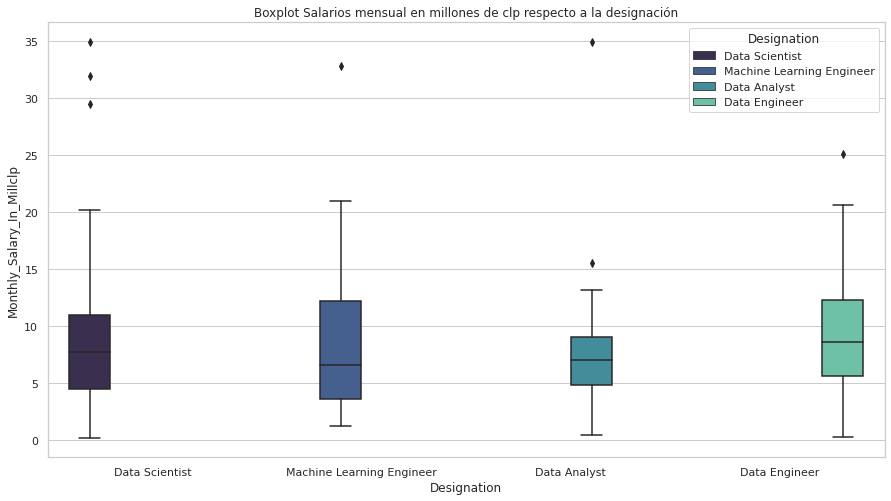

In [40]:
sns.set(style='whitegrid')
plt.subplots(figsize = (15,8))
sns.boxplot(y='Monthly_Salary_In_Millclp', 
            x='Designation', 
            data=df, 
            palette="mako",
            hue = 'Designation')
plt.title('Boxplot Salarios mensual en millones de clp respecto a la designación')
plt.show()

* Una observación interesante de este gráfico es que la media de salarios es parecida entre las 4 ocupaciones.
* También podemos notar que Data Analyst tiene una menor proyección salarial que los otros cargos.
> * Tambien se plantea la hipotesis de que la media salarial de Data Scientist es menor o igual que la de Data Engineer.



También nos interesa saber la distribución de los salarios por el nivel de experiencia dentro de cada designación:

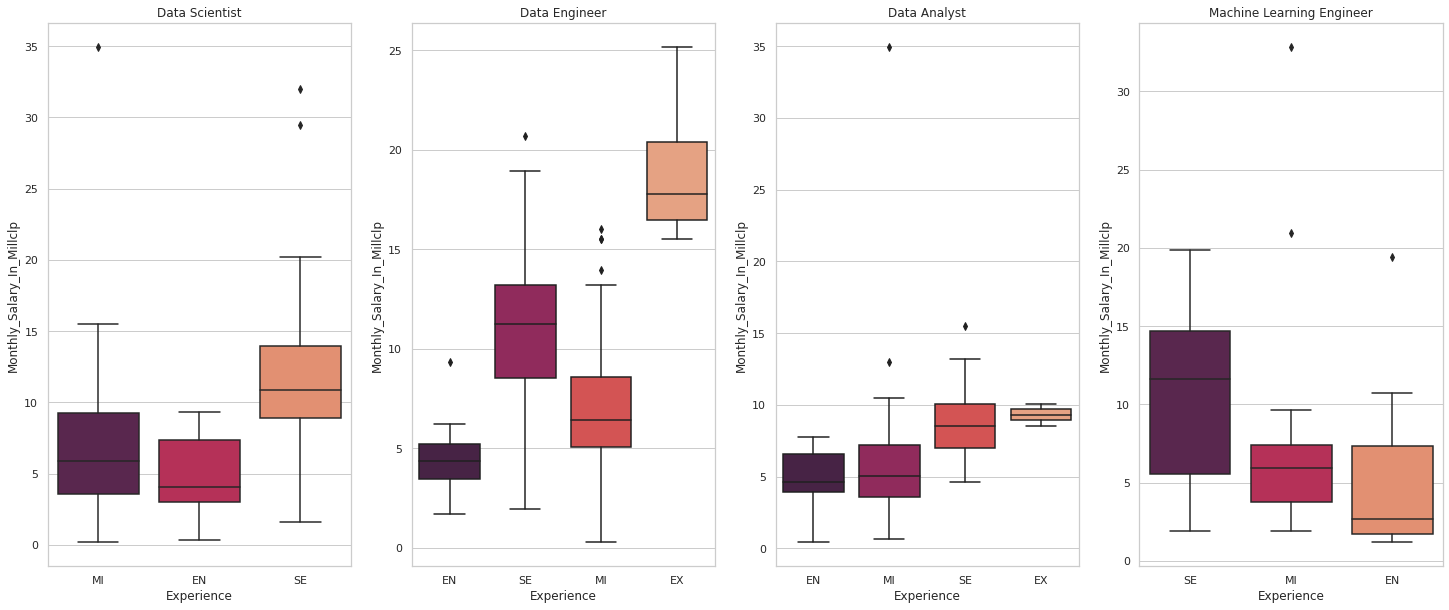

In [41]:
# Para cada categoría de Designation se separa por experiencia y se grafican los datos atípicos respecto a Monthly_Salary_In_Millclp.
m = 0
fig, axes = plt.subplots(1,4,figsize = (25,10))
for i in  Designation_2:
  df_n = df[df['Designation'] == i]
  df_m = df_n['Experience']
  sns.boxplot(x = df_m, 
              y = df_n['Monthly_Salary_In_Millclp'],
              ax = axes[m],
              palette="rocket")
  axes[m].set_title(f'{Designation_2[m]}')
  m = m + 1
plt.show()


* Podemos observar que hay varios salarios muy alejados del promedio aún considerando la separación por nivel de experiencia.
* Se observa que los salarios de trabajadores senior(SE) y expert(EX) son más altos que entry-level(EN) y mid-level(MI).\
> * Para el caso de Data Scientist y Data Analyst realizaremos un test de hipótesis para determinar si las diferencias entre mid-level(MI) y entry-level(EN)son estadísticamente significativas.

###**Preprocesamiento**

Nos enfocaremos en eliminar los valores más alejados utilizando el promedio de los datos, considerando la designación y la experiencia (e.j: promedio del salario de los Data Scientist EN).\
El criterio a utilizar depende de los promedios y desviaciones estandar salariales por designación.

In [42]:
n = 0
m = 0
for i in  Designation_2: 
  df_n = df[df['Designation'] == i]
  for j in df_n['Experience'].unique():
    df_m = df_n[df_n['Experience']==j]
    operación_mas = np.mean(df_m['Monthly_Salary_In_Millclp']) + 2*(np.std(df_m['Monthly_Salary_In_Millclp']))
    operación_menos = np.mean(df_m['Monthly_Salary_In_Millclp']) - 2*(np.std(df_m['Monthly_Salary_In_Millclp']))
    if operación_menos <0:
      operación_menos = 0
    for index,row in df_m.iterrows():
      if row['Monthly_Salary_In_Millclp']> operación_mas or row['Monthly_Salary_In_Millclp']< operación_menos:
        df.loc[index,'Monthly_Salary_In_Millclp'] = np.nan
df = df.dropna()

### **Gráficos**

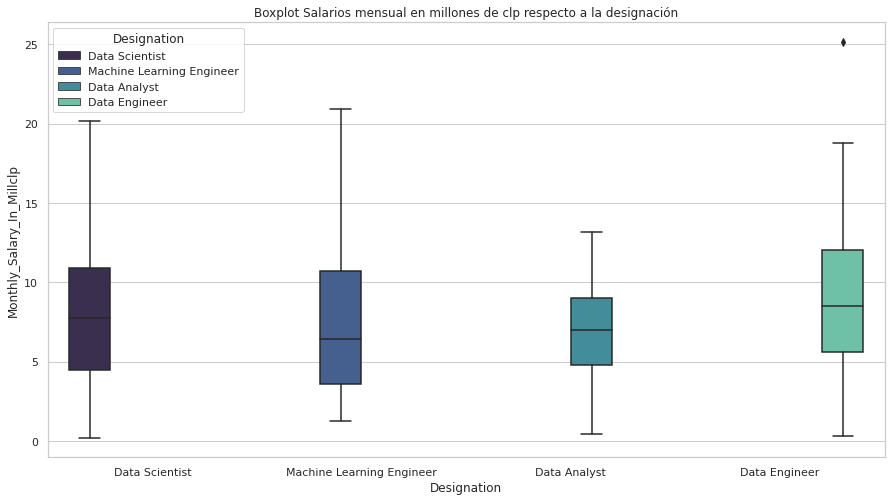

In [43]:
#Se grafican para visualizar nuevamente, luego de eliminar valores atípicos.
sns.set(style='whitegrid')
plt.subplots(figsize = (15,8))
sns.boxplot(y='Monthly_Salary_In_Millclp', 
            x='Designation', 
            data=df, 
            palette="mako",
            hue = 'Designation')
plt.title('Boxplot Salarios mensual en millones de clp respecto a la designación')
plt.show()

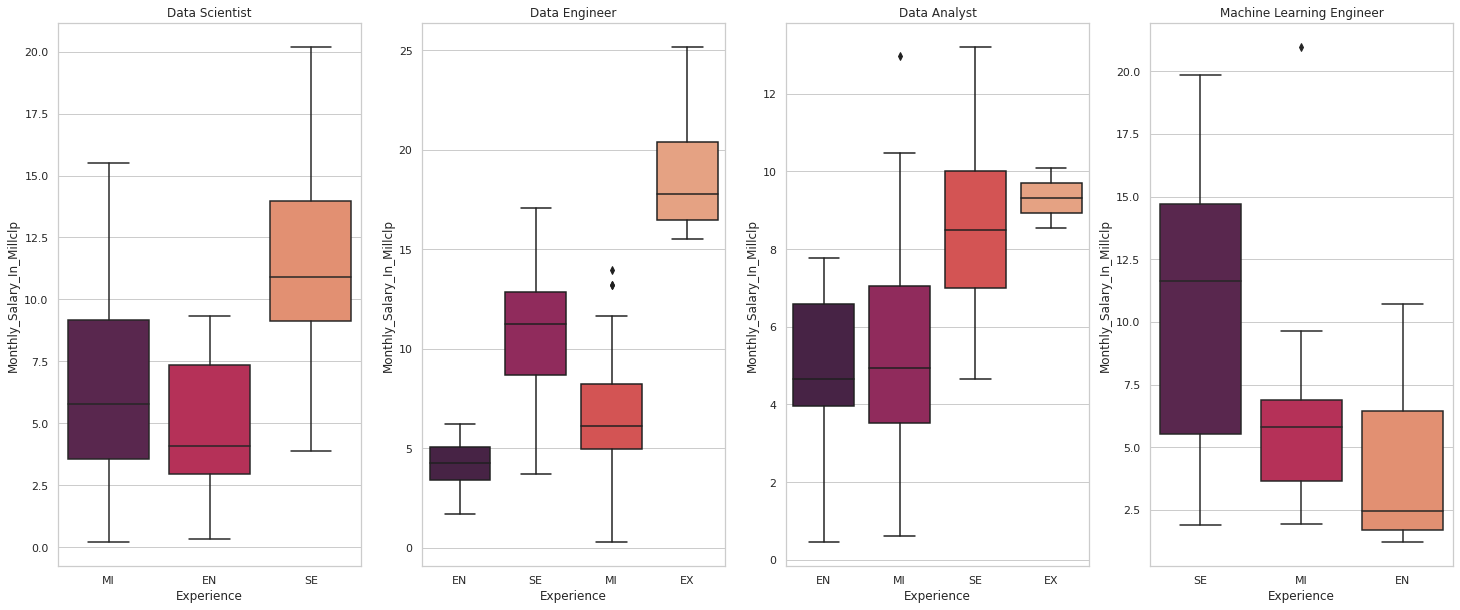

In [44]:
#Se grafican para visualizar nuevamente, luego de eliminar valores atípicos.
m = 0
fig, axes = plt.subplots(1,4,figsize = (25,10))
for i in  Designation_2:
  df_n = df[df['Designation'] == i]
  df_m = df_n['Experience']
  sns.boxplot(x = df_m, 
              y = df_n['Monthly_Salary_In_Millclp'],
              ax = axes[m],
              palette="rocket")
  axes[m].set_title(f'{Designation_2[m]}')
  m = m + 1
plt.show()

In [45]:
df.shape

(448, 9)

* **Medidas estadísticas:**



In [46]:
for i in  Designation_2:
  df_n = df[df['Designation'] == i]
  df_m = df_n['Monthly_Salary_In_Millclp']
  descripcion = df_m.describe()
  print(f'Estadísticas respecto al salario para {i}')
  print(descripcion)
  print('')
  print('---------------------------------------------------------')

Estadísticas respecto al salario para Data Scientist
count    160.000000
mean       8.161093
std        4.441207
min        0.221802
25%        4.475179
50%        7.758026
75%       10.892269
max       20.170868
Name: Monthly_Salary_In_Millclp, dtype: float64

---------------------------------------------------------
Estadísticas respecto al salario para Data Engineer
count    135.000000
mean       8.930812
std        4.358658
min        0.310321
25%        5.613398
50%        8.533829
75%       12.009425
max       25.136005
Name: Monthly_Salary_In_Millclp, dtype: float64

---------------------------------------------------------
Estadísticas respecto al salario para Data Analyst
count    104.000000
mean       7.045357
std        2.974378
min        0.471067
25%        4.790349
50%        7.007049
75%        8.995470
max       13.188645
Name: Monthly_Salary_In_Millclp, dtype: float64

---------------------------------------------------------
Estadísticas respecto al salario para Machi

* Podemos notar por las desviaciones estandar que los datos están más dispersos en Machine Learning y menos dispersos en Data Analyst.
* Data Scientist y Data Engineer tiene una dispersión de los datos parecida.


Con el fin de realizar un histograma, separamos 'Monthly_Salary_In_Millclp' en rangos de 0.5 millones de pesos: 

In [47]:
df['Salario_inferior_a'] = np.nan
intervalos = np.arange(0.5,26,0.5)
for i,row in df.iterrows():
  n=0
  while row['Monthly_Salary_In_Millclp']>intervalos[n]:
    n=n+1
  df.loc[i,'Salario_inferior_a'] = intervalos[n]

In [48]:
Scientist = df[df['Designation']=='Data Scientist']
Engineer = df[df['Designation']=='Data Engineer']
Machine = df[df['Designation']=='Machine Learning Engineer']
Analyst = df[df['Designation']=='Data Analyst']

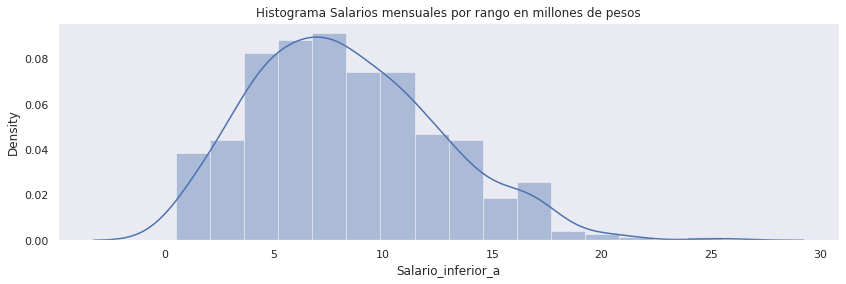

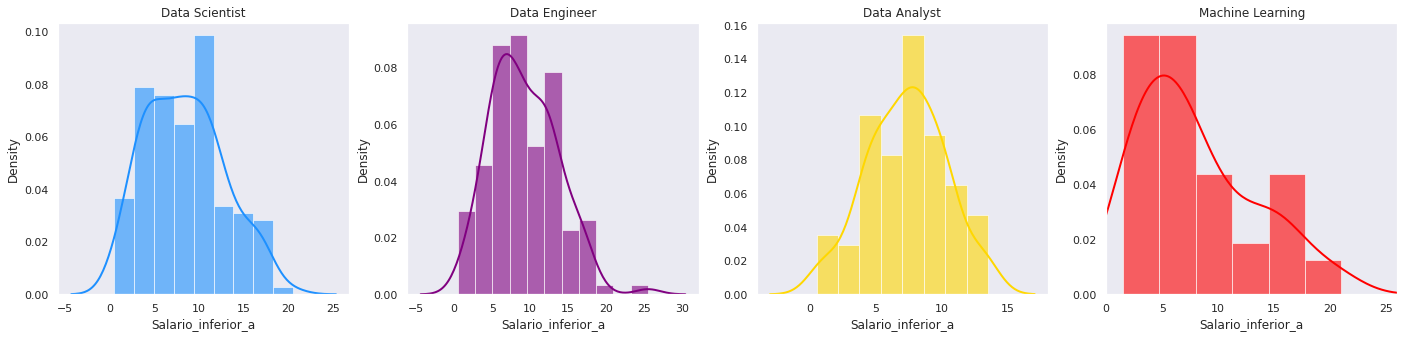

In [49]:
# Histogramas
sns.set(style='dark',)
plt.figure(figsize = (14,4))
plt.subplot(1,1,1)
sns.distplot(df['Salario_inferior_a']);
plt.title("Histograma Salarios mensuales por rango en millones de pesos")
plt.show()


kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
fig, axes = plt.subplots(1,4,figsize = (24,5)) 

sns.distplot(Scientist['Salario_inferior_a'], color="dodgerblue", ax = axes[0],**kwargs)
sns.distplot(Engineer['Salario_inferior_a'], color="purple",ax = axes[1], **kwargs)
sns.distplot(Analyst['Salario_inferior_a'], color="gold",ax = axes[2], **kwargs)
sns.distplot(Machine['Salario_inferior_a'], color="red",ax = axes[3], **kwargs)
plt.xlim(0,26)
axes[0].set_title("Data Scientist")
axes[1].set_title("Data Engineer")
axes[2].set_title("Data Analyst")
axes[3].set_title("Machine Learning")

plt.show()

* Podemos observar que las distribuciones en general parecieran ser normales, excepto la de Machine Learning.\
Esto lo probaremos con el correspondiente test de hipótesis.

##**Análisis Estadístico e Inferencial**

* ***Test para comparar salarios agrupados por Designación***

**Primero revisamos si la data esta normalmente distribuida**

- $H_{0}$: los datos se distribuyen normalmente.
- $H_{1}$: los datos no se distribuyen normalmente.

In [50]:
n=25
check_normality(Scientist['Salario_inferior_a'].sample(n))
check_normality(Engineer['Salario_inferior_a'].sample(n))

p value:0.1019
No se puede rechazar la hipótesis nula >> La data está normalmente distribuida
p value:0.4465
No se puede rechazar la hipótesis nula >> La data está normalmente distribuida


Se busca comparar si la diferencia entre la media de los sueldos de Data Scientist y Data Engineer es significativa:

* $H_{0}$: $\mu_{Scientist}\le \mu_{Engineer}$     
* $H_{1}$: $\mu_{Scientist}>  \mu_{Engineer}$


In [51]:
Ttest(Scientist['Salario_inferior_a'],Engineer['Salario_inferior_a'],4,25,una_cola= True)

['NO Gaussiano', 'NO Gaussiano', 'Gaussiano', 'Gaussiano']
['Gaussiano', 'NO Gaussiano', 'Gaussiano', 'Gaussiano']
['Las Varianzas son IGUALES en la muestra 1', 'Las Varianzas son IGUALES en la muestra 2', 'Las Varianzas son IGUALES en la muestra 3', 'Las Varianzas son IGUALES en la muestra 4']
['NO se Rechaza la Hipótesis Nula', 'NO se Rechaza la Hipótesis Nula', 'NO se Rechaza la Hipótesis Nula', 'NO se Rechaza la Hipótesis Nula']


* ***Test para comparar Sueldos de Data Scientist agrupados por Experiencia (EN) Y (MI)***

**Primero revisamos si la data esta normalmente distribuida**

- $H_{0}$: los datos se distribuyen normalmente.
- $H_{1}$: los datos no se distribuyen normalmente.

In [52]:
#Veamos Cuantos valores tienen nuestros datos, para ver si es apropiad extraer una muestra
print(Scientist['Salario_inferior_a'].where(Scientist['Experience']=='EN').dropna().count())
print(Scientist['Salario_inferior_a'].where(Scientist['Experience']=='MI').dropna().count())

27
68


In [53]:
n=25
check_normality(Scientist['Salario_inferior_a'].where(Scientist['Experience']=='EN').dropna().sample(n))
check_normality(Scientist['Salario_inferior_a'].where(Scientist['Experience']=='MI').dropna().sample(n))

p value:0.1284
No se puede rechazar la hipótesis nula >> La data está normalmente distribuida
p value:0.3753
No se puede rechazar la hipótesis nula >> La data está normalmente distribuida


Se busca comparar si la diferencia entre la media de los sueldos de Data Scientist Juniors e Intermedios es significativa estadisticamente:

$H_{0}$: $\mu_{EN}= \mu_{MI}$     
$H_{1}$: $\mu_{EN} \ne  \mu_{MI}$

In [54]:
Ttest(Scientist['Salario_inferior_a'].where(Scientist['Experience']=='EN'),Scientist['Salario_inferior_a'].where(Scientist['Experience']=='EN'),4,25,una_cola= False)

['Gaussiano', 'Gaussiano', 'Gaussiano', 'Gaussiano']
['Gaussiano', 'Gaussiano', 'Gaussiano', 'Gaussiano']
['Las Varianzas son IGUALES en la muestra 1', 'Las Varianzas son IGUALES en la muestra 2', 'Las Varianzas son IGUALES en la muestra 3', 'Las Varianzas son IGUALES en la muestra 4']
['NO se Rechaza la Hipótesis Nula', 'NO se Rechaza la Hipótesis Nula', 'NO se Rechaza la Hipótesis Nula', 'NO se Rechaza la Hipótesis Nula']


* ***Test para comparar Sueldos de Data Analyst agrupados por Experiencia (EN) Y (MI)***

**Primero revisamos si la data esta normalmente distribuida**

- $H_{0}$: los datos se distribuyen normalmente.
- $H_{1}$: los datos no se distribuyen normalmente.

In [55]:
#Veamos Cuantos valores tienen nuestros datos, para ver si es apropiad extraer una muestra
print(Analyst['Salario_inferior_a'].where(Analyst['Experience']=='EN').dropna().count())
print(Analyst['Salario_inferior_a'].where(Analyst['Experience']=='MI').dropna().count())

15
32


In [56]:
check_normality(Analyst['Salario_inferior_a'].where(Analyst['Experience']=='EN').dropna())
check_normality(Analyst['Salario_inferior_a'].where(Analyst['Experience']=='MI').dropna())

p value:0.0842
No se puede rechazar la hipótesis nula >> La data está normalmente distribuida
p value:0.1702
No se puede rechazar la hipótesis nula >> La data está normalmente distribuida


Se busca comparar si la diferencia entre la media de los sueldos de Data Analyst EN e MI es significativa estadisticamente:

$H_{0}$: $\mu_{EN}= \mu_{MI}$     
$H_{1}$: $\mu_{EN} \ne  \mu_{MI}$

In [57]:
Ttest(Analyst['Salario_inferior_a'].where(Analyst['Experience']=='EN').dropna() ,Analyst['Salario_inferior_a'].where(Analyst['Experience']=='EN').dropna() ,1,tamaño_muestras = False,una_cola= False)

['Gaussiano']
['Gaussiano']
['Las Varianzas son IGUALES en la muestra 1']
['NO se Rechaza la Hipótesis Nula']


## **Conclusiones** 

* Del primer test de hipotesis podemos decir que la media de salarios mensuales en millones de clp de data scientist es menor o igual que la de Data Engineer.

* Del segundo test de hipótesis podemos decir que la media de salarios de EN y MI son iguales estadísticamente

* Del tercer test de hipótesis podemos decir que en el caso de data analyst la media de salarios para un EN y un MI también son iguales.

##**CLASIFICACIÓN**

### PREPROCESAMIENTO

#### **Data Cleaning**

In [58]:
df['Working_Year'].value_counts()

2022    272
2021    131
2020     45
Name: Working_Year, dtype: int64

Utilizaremos el dataframe original, pero sin la variable working_year pues la consideramos irrelevante para el estudio. 

In [59]:
df2 = df.iloc[:,1:9]
df2.head()

,Designation,Experience,Employment_Status,Employee_Location,Company_Location,Company_Size,Remote_Working_Ratio,Monthly_Salary_In_Millclp
0,Data Scientist,MI,FT,DE,DE,L,0,6.193465
4,Machine Learning Engineer,SE,FT,US,US,L,50,11.637039
5,Data Analyst,EN,FT,US,US,L,100,5.585779
7,Data Scientist,MI,FT,HU,HU,L,50,2.772331
8,Data Analyst,MI,FT,US,US,L,100,10.473336


Visualizamos las medidas de estadística descriptiva.

In [60]:
df2['Monthly_Salary_In_Millclp'].describe()

count    448.000000
mean       8.090010
std        4.258419
min        0.221802
25%        4.923612
50%        7.698289
75%       10.861237
max       25.136005
Name: Monthly_Salary_In_Millclp, dtype: float64

Usamos z-score para buscar outliers basandonos en la media y la desviación
estandar.

In [61]:
mean = np.mean(df2['Monthly_Salary_In_Millclp'])
std = np.std(df2['Monthly_Salary_In_Millclp'])
threshold = 3
outlier = []
for i in df2['Monthly_Salary_In_Millclp']:
    z = (i-mean)/std
    if z > threshold:
        outlier.append(i)
print('outlier in dataset is', outlier)

outlier in dataset is [20.946670875, 25.136005049999998]


In [62]:
df2['Employment_Status'].value_counts()

FT    437
PT      6
CT      3
FL      2
Name: Employment_Status, dtype: int64

Analizamos la columna Employement_status y notamos que la mayoría trabaja full-time, por lo que nos quedaremos solo con esa modalidad.

Eliminamos los outliers y las filas con Employement_status PT, CT Y FL.

In [63]:
df2.drop(df2[(df2['Monthly_Salary_In_Millclp'] == 20.946670875 ) | (df2['Monthly_Salary_In_Millclp'] == 25.136005049999998)].index, inplace=True)
df2.drop(df2[(df2['Employment_Status'] == 'PT' ) | (df2['Employment_Status'] == 'CT') | (df2['Employment_Status'] == 'FL')].index, inplace=True)

Eliminamos la columna Employment_Status ya que todos son modalidad FT.

In [64]:
df2 = df2.drop(['Employment_Status'],axis=1)

Realizamos nuevamente la visualización de las medidas estadísticas para analizar si los cambios realizados tienen alto impacto en la media y desviación estandar.

In [65]:
df2['Monthly_Salary_In_Millclp'].describe()

count    436.000000
mean       8.113638
std        4.127923
min        0.221802
25%        4.956041
50%        7.733201
75%       10.861237
max       20.170868
Name: Monthly_Salary_In_Millclp, dtype: float64

Notemos que la media y la desviación estandar permanecieron prácticamente iguales.

#### **Data transformation**

Redondeamos a un decimal el valor de Monthly_Salary_In_Millclp para facilitar su uso.

In [66]:
df2['Monthly_Salary_In_Millclp'] = df2['Monthly_Salary_In_Millclp'].round(1)

In [67]:
df2.head()

,Designation,Experience,Employee_Location,Company_Location,Company_Size,Remote_Working_Ratio,Monthly_Salary_In_Millclp
0,Data Scientist,MI,DE,DE,L,0,6.2
4,Machine Learning Engineer,SE,US,US,L,50,11.6
5,Data Analyst,EN,US,US,L,100,5.6
7,Data Scientist,MI,HU,HU,L,50,2.8
8,Data Analyst,MI,US,US,L,100,10.5


Para transformar a variables numéricas utilizamos la frecuencia en que ese repiten las clases y les designamos ese número. Por ejemplo en la columna Employee_Location US, se repite 251 veces por lo que le asignamos ese número.

In [68]:
columnas = ['Designation','Employee_Location','Company_Location','Company_Size','Experience']
for i in columnas:
  df2[i] = df2.groupby(i)[i].transform('count')

In [69]:
df2.head()

,Designation,Experience,Employee_Location,Company_Location,Company_Size,Remote_Working_Ratio,Monthly_Salary_In_Millclp
0,157,165,11,15,125,0,6.2
4,46,208,251,262,125,50,11.6
5,102,58,251,262,125,100,5.6
7,157,165,1,1,125,50,2.8
8,102,165,251,262,125,100,10.5


Realizamos una discretización por igual frecuencia de la columna  Monthly_Salary_In_Millclp para poder utilizarla como variable objetivo posteriormente.

In [70]:
etiquetas = [i for i in range(1,5)]

In [71]:
etiquetas

[1, 2, 3, 4]

In [72]:
precio_discretizado, bins = pd.qcut(df2['Monthly_Salary_In_Millclp'], 4, labels=etiquetas, retbins=True, precision=3, duplicates='raise')

In [73]:
df2['Salario_Discretizado'] = precio_discretizado

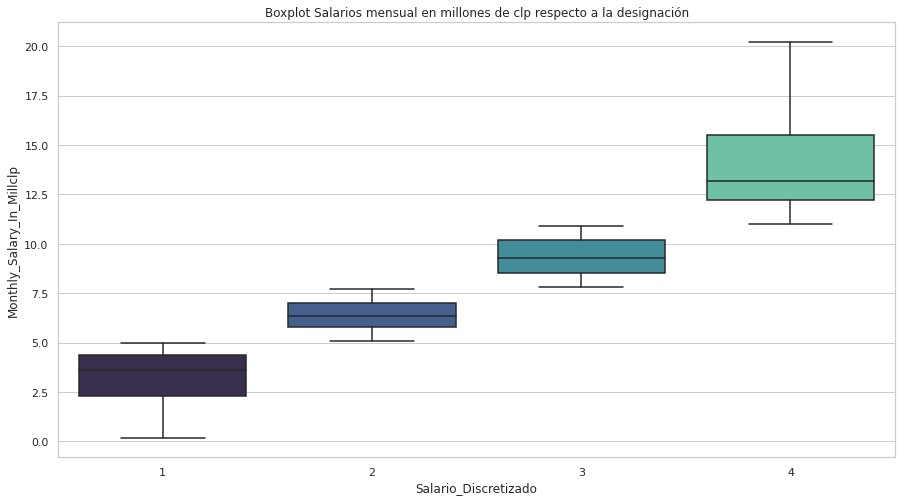

In [74]:
#Se grafican para visualizar nuevamente, luego de eliminar valores atípicos.
sns.set(style='whitegrid')
plt.subplots(figsize = (15,8))
sns.boxplot(y='Monthly_Salary_In_Millclp', 
            x='Salario_Discretizado', 
            data=df2, 
            palette="mako")
plt.title('Boxplot Salarios mensual en millones de clp respecto a la designación')
plt.show()

In [75]:
bins

array([ 0.2 ,  5.  ,  7.75, 10.9 , 20.2 ])

Realizada la discretización, eliminamos la columna Monthly_Salary_In_Millclp.



In [76]:
df4 = df2.copy()
df2 = df2.drop(['Monthly_Salary_In_Millclp'],axis = 1)

Realizamos el escalamiento de nuestras variables.

In [77]:
Escalamiento_min_max(df2,'Designation')
Escalamiento_min_max(df2,'Experience')
Escalamiento_min_max(df2,'Employee_Location')
Escalamiento_min_max(df2,'Company_Location')
Escalamiento_min_max(df2,'Company_Size')
Escalamiento_min_max(df2,'Remote_Working_Ratio')

Dado que nuestras variables se distribuyen de manera normal realizaremos análisis de correlación con el método de Pearson.

In [78]:
corr_matrix = df2.corr(method='pearson')
corr_matrix

,Designation,Experience,Employee_Location,Company_Location,Company_Size,Remote_Working_Ratio
Designation,1.000000,0.002129,0.049331,0.052217,0.041157,-0.065534
Experience,0.002129,1.000000,0.294399,0.309249,0.261288,0.030622
Employee_Location,0.049331,0.294399,1.000000,0.944170,0.288747,0.147730
Company_Location,0.052217,0.309249,0.944170,1.000000,0.242590,0.175532
Company_Size,0.041157,0.261288,0.288747,0.242590,1.000000,0.051953
Remote_Working_Ratio,-0.065534,0.030622,0.147730,0.175532,0.051953,1.000000


In [79]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy.
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
20,Company_Location,Employee_Location,0.944170,0.944170
15,Employee_Location,Company_Location,0.944170,0.944170
9,Experience,Company_Location,0.309249,0.309249
19,Company_Location,Experience,0.309249,0.309249
13,Employee_Location,Experience,0.294399,0.294399
8,Experience,Employee_Location,0.294399,0.294399
16,Employee_Location,Company_Size,0.288747,0.288747
26,Company_Size,Employee_Location,0.288747,0.288747
10,Experience,Company_Size,0.261288,0.261288
25,Company_Size,Experience,0.261288,0.261288


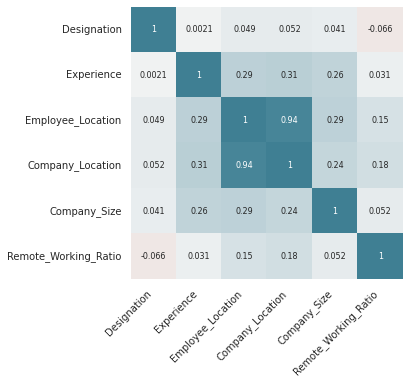

In [80]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

Notemos que los únicos que tienen una alta correlación son Company_Location y Employee_Location.

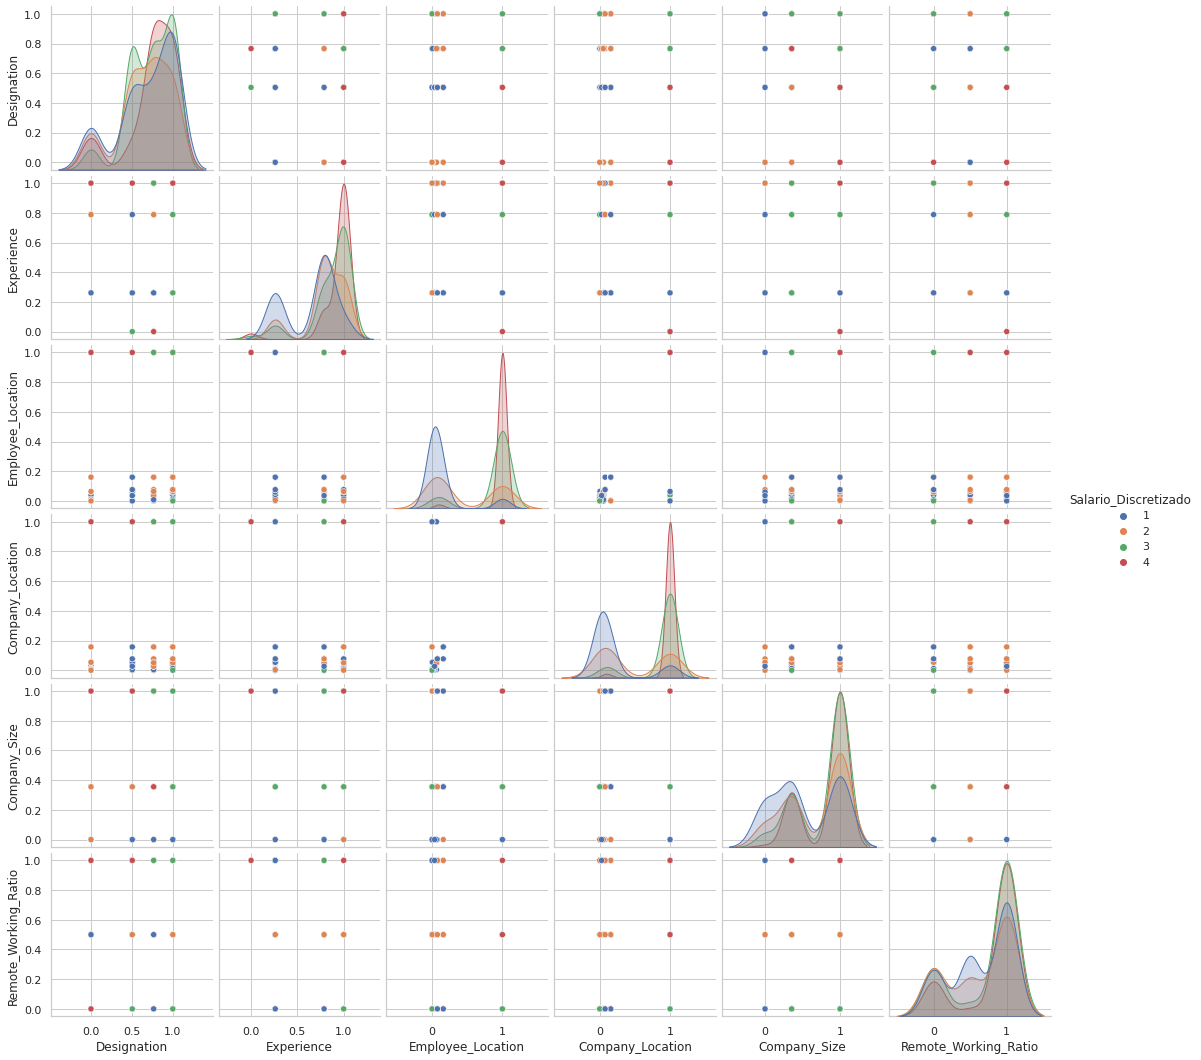

In [81]:
sns.pairplot(df2, hue = 'Salario_Discretizado') 
plt.show() 

#### **Data Enrichment**

In [82]:
df2 = df2.rename(columns={"Salario_Discretizado":"Y"})

In [83]:
df2.head()

,Designation,Experience,Employee_Location,Company_Location,Company_Size,Remote_Working_Ratio,Y
0,1.000000,0.788177,0.04,0.05364,0.35545,0.0,2
4,0.000000,1.000000,1.00,1.00000,0.35545,0.5,4
5,0.504505,0.261084,1.00,1.00000,0.35545,1.0,2
7,1.000000,0.788177,0.00,0.00000,0.35545,0.5,1
8,0.504505,0.788177,1.00,1.00000,0.35545,1.0,3


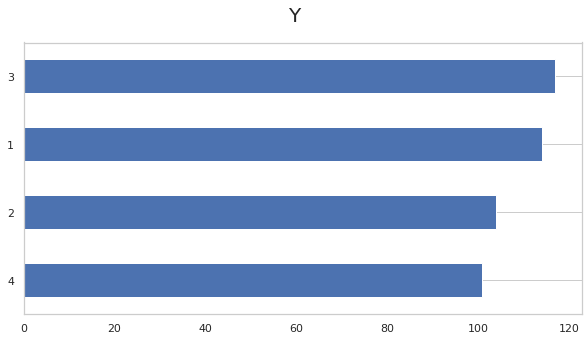

In [84]:
ax = df2['Y'].value_counts().sort_values().plot(kind="barh", figsize=(10,5))
totals = []
for i in ax.patches:
    totals.append(i.get_width())
ax.grid(axis="x")
plt.suptitle('Y', fontsize=20)
plt.show()

Podemos ver gráficamente que las clases de la variable objetivo están balanceadas.

#### **Data Validation**

división en train y test

In [85]:
df2_train, df2_test = model_selection.train_test_split(df2, test_size=0.3, shuffle=False) 
print("X_train shape:", df2_train.drop('Y', axis=1).shape, "| X_test shape:", df2_test.drop('Y', axis=1).shape)
print(df2_train.shape[1], "features:", df2_train.drop('Y', axis=1).columns.to_list())

X_train shape: (305, 6) | X_test shape: (131, 6)
7 features: ['Designation', 'Experience', 'Employee_Location', 'Company_Location', 'Company_Size', 'Remote_Working_Ratio']


In [86]:
X = df2.drop(columns='Y')
Y = df2['Y']
X_train = df2_train.drop(columns='Y').values
y_train = df2_train["Y"].values
X_test = df2_test.drop(columns='Y').values
y_test = df2_test["Y"].values

##**MODELOS DE CLASIFICACIÓN**

### **Random forest**

In [87]:
rf = ensemble.RandomForestClassifier()

In [88]:
param_dic = {'n_estimators':[100,300,50,150],     #número de árboles incluidos en el modelo.
             'max_depth':[3,5,7],                 #profundidad máxima que pueden alcanzar los árboles.
             'min_samples_split':[3,10,30],       #número mínimo de observaciones que debe de tener un nodo para que pueda dividirse.
             'min_samples_leaf':[3,5,10],         #número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división.
             'max_features':[2,3,5]}              #número de predictores considerados a en cada división.
             

In [89]:
grid_search = model_selection.RandomizedSearchCV(rf, param_dic,cv =10, scoring='accuracy', refit='f1').fit(X_train, y_train)
rf = grid_search.best_estimator_
rf

RandomForestClassifier(max_depth=5, max_features=3, min_samples_leaf=3,
                       min_samples_split=30, n_estimators=150)

In [90]:
validacion_cruzada(rf)

[0.54545455 0.5        0.5        0.59090909 0.56818182 0.63636364
 0.37209302 0.48837209 0.55813953 0.53488372]
0.5294397463002115


**Métricas antes de la selección de características**

In [91]:
metricas(rf,X_test,y_test)

accuracy score : 0.5419847328244275
Precision score : 0.5419847328244275
recall score : 0.5209967673816706
f1 score : 0.4749354933553879


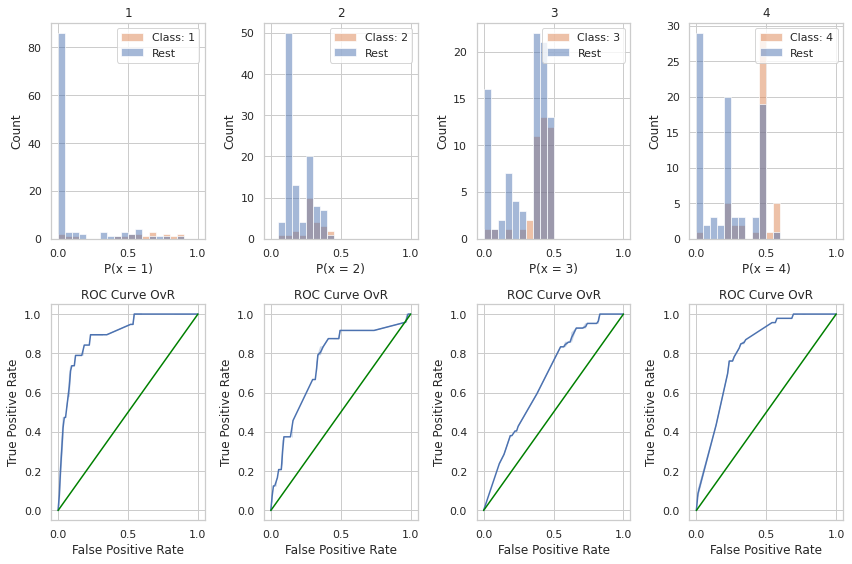

In [92]:
ROC_AUC(rf,df2_test)

Selección de características

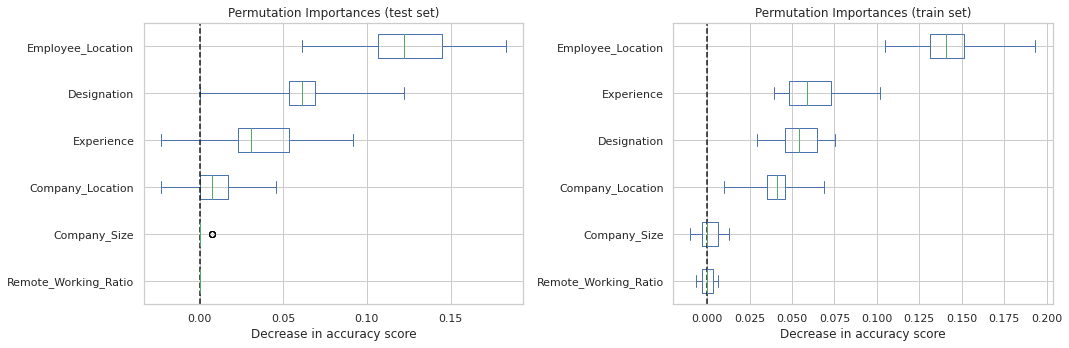

In [93]:
seleccion_caracteristicas(rf)

Eliminamos la variable Remote_Working_Ratio y Company_Size y entrenamos el modelo.

In [94]:
df3 = df2.drop(columns='Remote_Working_Ratio')
df3 = df3.drop(columns='Company_Size')

df2_train, df2_test = model_selection.train_test_split(df3, test_size=0.3, shuffle=False) 
print("X_train shape:", df2_train.drop('Y', axis=1).shape, "| X_test shape:", df2_test.drop('Y', axis=1).shape)
print(df2_train.shape[1], "features:", df2_train.drop('Y', axis=1).columns.to_list())

X = df2.drop(columns='Y')
Y = df2['Y']
X_train = df2_train.drop(columns='Y').values
y_train = df2_train["Y"].values
X_test = df2_test.drop(columns='Y').values
y_test = df2_test["Y"].values

X_train shape: (305, 4) | X_test shape: (131, 4)
5 features: ['Designation', 'Experience', 'Employee_Location', 'Company_Location']


In [95]:
grid_search = model_selection.RandomizedSearchCV(rf, param_dic,cv =10, scoring='accuracy', refit='f1').fit(X_train, y_train)
rf = grid_search.best_estimator_

Validación cruzada

In [96]:
rf

RandomForestClassifier(max_depth=5, max_features=2, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=300)

In [97]:
validacion_cruzada(rf)

[0.5        0.5        0.40909091 0.54545455 0.56818182 0.61363636
 0.37209302 0.48837209 0.53488372 0.53488372]
0.5066596194503171


### **Métricas**

In [98]:
metricas(rf,X_test,y_test)

accuracy score : 0.5419847328244275
Precision score : 0.5419847328244275
recall score : 0.5209967673816706
f1 score : 0.47532078218653634


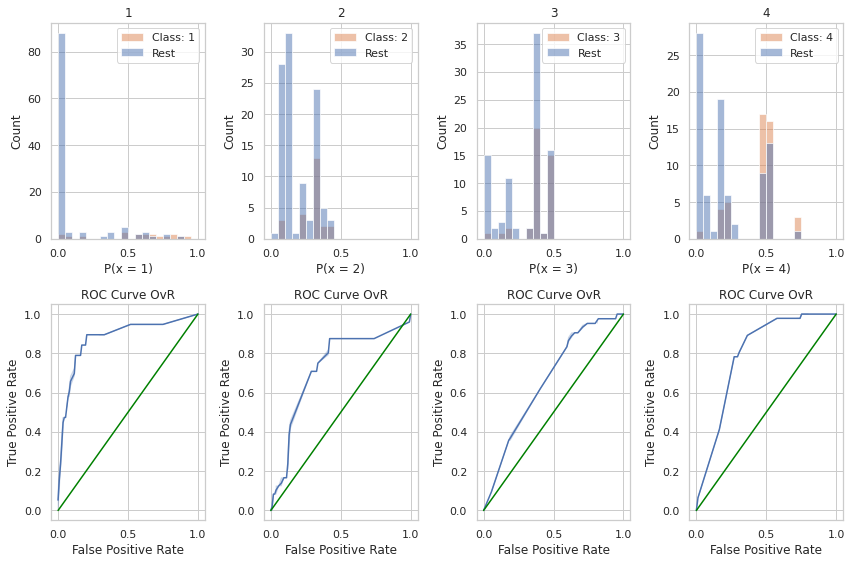

In [99]:
ROC_AUC(rf,df2_test)

###**Gradient boosting**

In [100]:
df2_train, df2_test = model_selection.train_test_split(df2, test_size=0.3, shuffle=False) 
print("X_train shape:", df2_train.drop('Y', axis=1).shape, "| X_test shape:", df2_test.drop('Y', axis=1).shape)
print(df2_train.shape[1], "features:", df2_train.drop('Y', axis=1).columns.to_list())

X_train shape: (305, 6) | X_test shape: (131, 6)
7 features: ['Designation', 'Experience', 'Employee_Location', 'Company_Location', 'Company_Size', 'Remote_Working_Ratio']


In [101]:
X = df2.drop(columns='Y')
Y = df2['Y']
X_train = df2_train.drop(columns='Y').values
y_train = df2_train["Y"].values
X_test = df2_test.drop(columns='Y').values
y_test = df2_test["Y"].values

In [102]:
gb = ensemble.GradientBoostingClassifier()

In [103]:
param_dic = {'learning_rate':[0.01,0.03,0.1],       #reduce la contribución de cada árbol multiplicando su influencia original por este valor.
             'n_estimators':[100,300,50,150],       #número de árboles incluidos en el modelo.
             'max_depth':[3,5,7],                   #profundidad máxima que pueden alcanzar los árboles.
             'min_samples_split':[3,10,30],         #número mínimo de observaciones que debe de tener un nodo para que pueda dividirse.
             'min_samples_leaf':[3,5,10],           #número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división.
             'max_features':[2,5],                  #número de predictores considerados a en cada división.
             'subsample':[0.75,0.85,0.95,1]}        #proporción de observaciones utilizadas para el ajsute de cada árbol.

In [104]:
grid_search = model_selection.RandomizedSearchCV(gb, param_dic,cv =10, scoring='accuracy', refit='f1').fit(X_train, y_train)
gb = grid_search.best_estimator_
gb

GradientBoostingClassifier(learning_rate=0.01, max_depth=7, max_features=5,
                           min_samples_leaf=3, min_samples_split=30,
                           subsample=0.95)

In [105]:
validacion_cruzada(gb)

[0.52272727 0.45454545 0.47727273 0.52272727 0.54545455 0.52272727
 0.44186047 0.46511628 0.51162791 0.55813953]
0.5022198731501057


**Métricas antes de la selección de características**

In [106]:
metricas(gb,X_test,y_test)

accuracy score : 0.5190839694656488
Precision score : 0.5190839694656488
recall score : 0.49971053616793526
f1 score : 0.44269330438119225


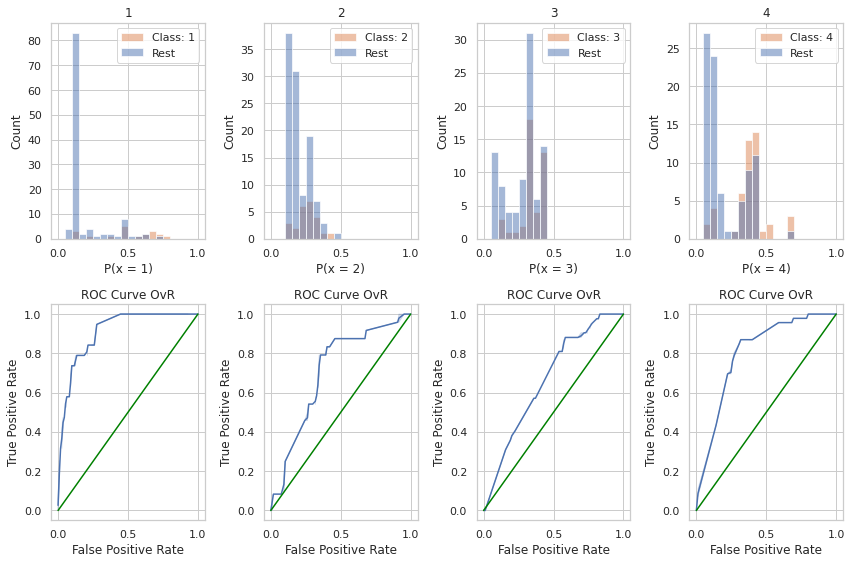

In [107]:
ROC_AUC(gb,df2_test)

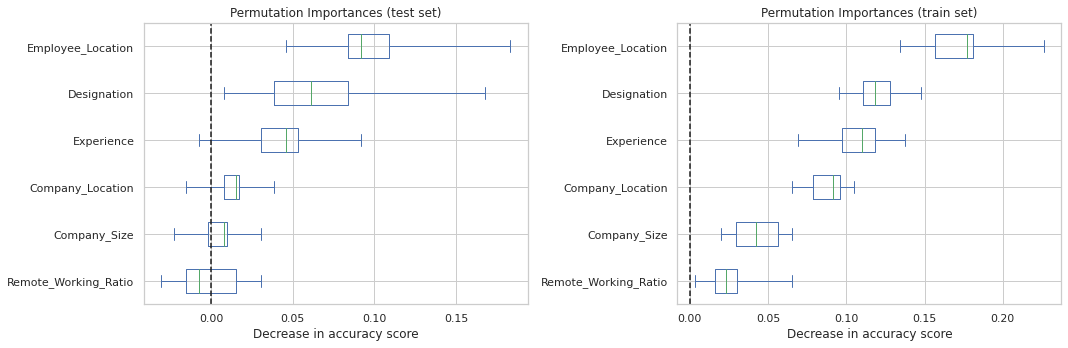

In [108]:
seleccion_caracteristicas(gb)

In [109]:
df3 = df2.drop(columns='Remote_Working_Ratio')
df3 = df3.drop(columns='Company_Size')

df2_train, df2_test = model_selection.train_test_split(df3, test_size=0.3, shuffle=False) 
print("X_train shape:", df2_train.drop('Y', axis=1).shape, "| X_test shape:", df2_test.drop('Y', axis=1).shape)
print(df2_train.shape[1], "features:", df2_train.drop('Y', axis=1).columns.to_list())

X = df2.drop(columns='Y')
Y = df2['Y']
X_train = df2_train.drop(columns='Y').values
y_train = df2_train["Y"].values
X_test = df2_test.drop(columns='Y').values
y_test = df2_test["Y"].values

X_train shape: (305, 4) | X_test shape: (131, 4)
5 features: ['Designation', 'Experience', 'Employee_Location', 'Company_Location']


In [110]:
grid_search = model_selection.RandomizedSearchCV(gb, param_dic,cv =10, scoring='accuracy', refit='f1').fit(X_train, y_train)
gb = grid_search.best_estimator_
gb

GradientBoostingClassifier(max_depth=5, max_features=2, min_samples_leaf=5,
                           min_samples_split=3, subsample=0.95)

In [111]:
validacion_cruzada(gb)

[0.54545455 0.45454545 0.54545455 0.43181818 0.54545455 0.52272727
 0.55813953 0.48837209 0.46511628 0.51162791]
0.5068710359408034


### **Métricas**

In [112]:
metricas(gb,X_test,y_test)

accuracy score : 0.549618320610687
Precision score : 0.549618320610687
recall score : 0.5209490942488538
f1 score : 0.49826764115496663


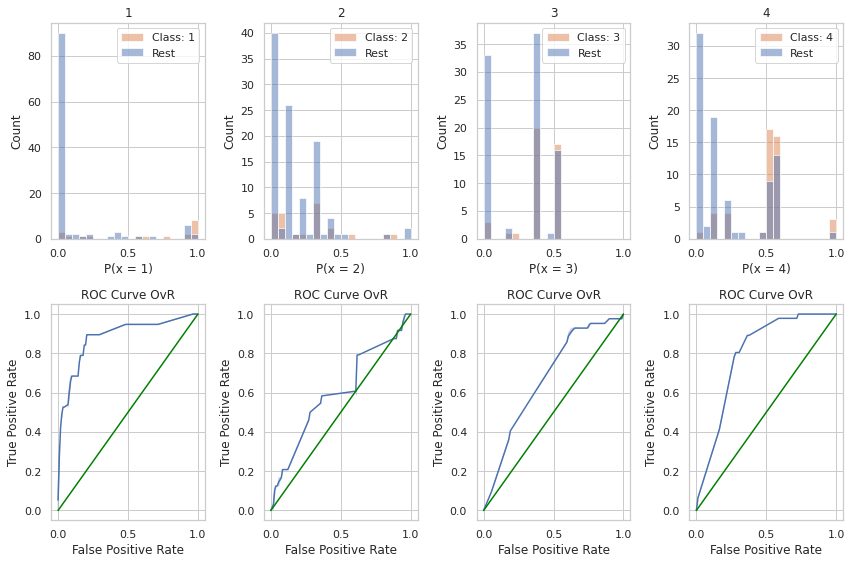

In [113]:
ROC_AUC(gb,df2_test)

### **Extreme Gradient Boosting**

* XGBoost es un algoritmo de aprendizaje automático basado en un árbol de decisiones y utiliza el principio de boosting.
* Genera múltiples modelos de predicción 'débiles' secuencialmente y cada uno de estos toma el resultado del modelo anterior para generar un modelo 'más fuerte'.
* Si un nuevo modelo tiene mejores resultados, entonces se toma este como base para realizar modificaciones.
* Si por el contrario tiene peores resultados, se regresa al modelo anterior y se modifica este de una manera diferente.
* Este proceso se repite hasta llegar a un punto en el que la diferencia entre modelos consecutivos es insignificante.


Diferencias con Gradient Boosting:
* xgboost usa una formalización de modelo más regularizada para controlar el sobreajuste, lo que le da un mejor rendimiento.
* mejor utilización de la memoria caché del procesador, lo que lo hace más rápido.
* Mejor compatibilidad con el procesamiento multinúcleo, lo que reduce el tiempo total de entrenamiento.

> * Estas diferencias se ven claramente en bases de datos muy grandes.



Diferencias con random forest:
* La principal diferencia entre los algoritmos XGBoost y Random Forest es que en el primero el usuario define la extensión de los árboles mientras que en el segundo los árboles crecen hasta su máxima extensión.

In [124]:
df2_train, df2_test = model_selection.train_test_split(df2, test_size=0.3, shuffle=False) 
print("X_train shape:", df2_train.drop('Y', axis=1).shape, "| X_test shape:", df2_test.drop('Y', axis=1).shape)
print(df2_train.shape[1], "features:", df2_train.drop('Y', axis=1).columns.to_list())

X_train shape: (305, 6) | X_test shape: (131, 6)
7 features: ['Designation', 'Experience', 'Employee_Location', 'Company_Location', 'Company_Size', 'Remote_Working_Ratio']


In [125]:
X = df2.drop(columns='Y')
Y = df2['Y']
X_train = df2_train.drop(columns='Y').values
y_train = df2_train["Y"].values
X_test = df2_test.drop(columns='Y').values
y_test = df2_test["Y"].values

In [126]:
import xgboost
xgb = xgboost.XGBClassifier()

In [127]:
parameters = {'objective': ['multi:softmax'],   #Objetivo de la clasificación, en este caso multiclase.
              'learning_rate':[0.05,0.1],       #reduce la contribución de cada árbol multiplicando su influencia original por este valor.
              'max_depth':[3,5,7],              #profundidad máxima que pueden alcanzar los árboles.
              'n_estimators' : [100,200]}       #número de árboles incluidos en el modelo.

In [159]:
grid_search = model_selection.RandomizedSearchCV(xgb, parameters,cv =10, scoring='accuracy', refit='f1').fit(X_train, y_train)

In [129]:
xgB = grid_search.best_estimator_
xgB

XGBClassifier(objective='multi:softprob')

In [130]:
validacion_cruzada(xgB)

[0.54545455 0.40909091 0.45454545 0.5        0.54545455 0.47727273
 0.46511628 0.55813953 0.55813953 0.53488372]
0.5048097251585624


**Métricas antes de la selección de características**

In [131]:
metricas(xgB,X_test,y_test)

accuracy score : 0.5343511450381679
Precision score : 0.5343511450381679
recall score : 0.5061328421658855
f1 score : 0.47846755879616676


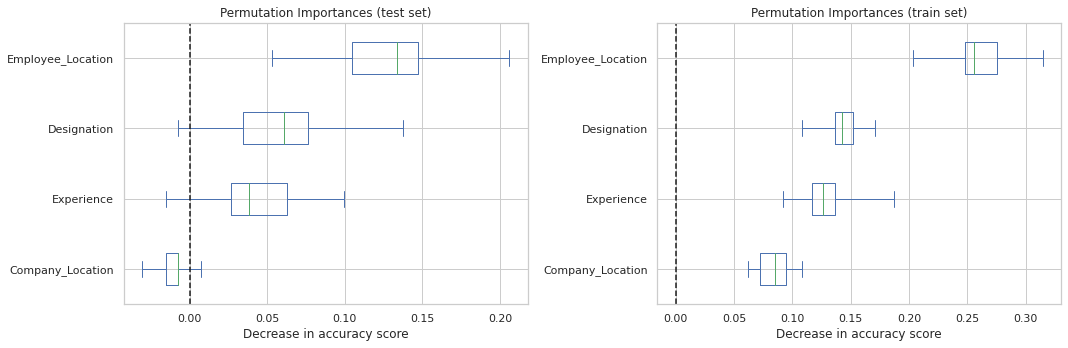

In [140]:
seleccion_caracteristicas(xgB)

In [135]:
df3 = df2.drop(columns='Remote_Working_Ratio')
df3 = df3.drop(columns='Company_Size')

df2_train, df2_test = model_selection.train_test_split(df3, test_size=0.3, shuffle=False) 
print("X_train shape:", df2_train.drop('Y', axis=1).shape, "| X_test shape:", df2_test.drop('Y', axis=1).shape)
print(df2_train.shape[1], "features:", df2_train.drop('Y', axis=1).columns.to_list())

X = df2.drop(columns='Y')
Y = df2['Y']
X_train = df2_train.drop(columns='Y').values
y_train = df2_train["Y"].values
X_test = df2_test.drop(columns='Y').values
y_test = df2_test["Y"].values

X_train shape: (305, 4) | X_test shape: (131, 4)
5 features: ['Designation', 'Experience', 'Employee_Location', 'Company_Location']


In [136]:
grid_search = model_selection.GridSearchCV(xgb, parameters,cv =10, scoring='accuracy', refit='f1').fit(X_train, y_train)
xgB = grid_search.best_estimator_
xgB

XGBClassifier(learning_rate=0.05, max_depth=5, objective='multi:softprob')

In [137]:
validacion_cruzada(xgB)

[0.52272727 0.45454545 0.5        0.47727273 0.54545455 0.54545455
 0.51162791 0.41860465 0.55813953 0.53488372]
0.5068710359408033


### Métricas

In [138]:
metricas(xgB,X_test,y_test)

accuracy score : 0.5267175572519084
Precision score : 0.5267175572519084
recall score : 0.49416338097291845
f1 score : 0.45584067880253154


##**MODELO DE REGRESIÓN**

###Preparación de datos

In [141]:
df4 = df4.drop(['Salario_Discretizado'], axis=1)
df4 = df4.rename({'Monthly_Salary_In_Millclp':'Y'})

In [142]:
df4 = df4.rename(columns={'Monthly_Salary_In_Millclp':'Y'})
Escalamiento_min_max(df4,'Designation')
Escalamiento_min_max(df4,'Experience')
Escalamiento_min_max(df4,'Employee_Location')
Escalamiento_min_max(df4,'Company_Location')
Escalamiento_min_max(df4,'Company_Size')
Escalamiento_min_max(df4,'Remote_Working_Ratio')
Escalamiento_min_max(df4,'Y')
df4

,Designation,Experience,Employee_Location,Company_Location,Company_Size,Remote_Working_Ratio,Y
0,1.000000,0.788177,0.040,0.053640,0.35545,0.0,0.300
4,0.000000,1.000000,1.000,1.000000,0.35545,0.5,0.570
5,0.504505,0.261084,1.000,1.000000,0.35545,1.0,0.270
7,1.000000,0.788177,0.000,0.000000,0.35545,0.5,0.130
8,0.504505,0.788177,1.000,1.000000,0.35545,1.0,0.515
...,...,...,...,...,...,...,...
601,0.504505,0.261084,0.076,0.076628,1.00000,0.0,0.190
602,0.765766,1.000000,1.000,1.000000,1.00000,1.0,0.585
603,0.765766,1.000000,1.000,1.000000,1.00000,1.0,0.480
604,0.504505,1.000000,1.000,1.000000,1.00000,0.0,0.490


In [143]:
df4_train, df4_test = model_selection.train_test_split(df4, test_size=0.3, shuffle=False) 
print("X_train shape:", df4_train.drop('Y', axis=1).shape, "| X_test shape:", df4_test.drop('Y', axis=1).shape)
print(df4_train.shape[1], "features:", df4_train.drop('Y', axis=1).columns.to_list())

X_train shape: (305, 6) | X_test shape: (131, 6)
7 features: ['Designation', 'Experience', 'Employee_Location', 'Company_Location', 'Company_Size', 'Remote_Working_Ratio']


In [144]:
X = df4.drop(columns='Y')
Y = df4['Y']
X_train = df4_train.drop(columns='Y').values
y_train = df4_train["Y"].values
X_test = df4_test.drop(columns='Y').values
y_test = df4_test["Y"].values

###Gradient Boosting Regressor

In [145]:
model_base = ensemble.GradientBoostingRegressor()

In [146]:
param_dic = {'learning_rate':[0.3,0.1,0.03,0.01,0.003,0.001],  #reduce la contribución de cada árbol multiplicando su influencia original por este valor.
             'n_estimators':[100,300,150,1000],                #número de árboles incluidos en el modelo.
             'max_depth':[2,3,4,5,6,7],                        #profundidad máxima que pueden alcanzar los árboles.
             'min_samples_split':[3,10,30,100],                #número mínimo de observaciones que debe de tener un nodo para que pueda dividirse.
             'min_samples_leaf':[1,3,5,7,9],                   #número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división.
             'max_features':[2,3,4,5,6,7],                     #número de predictores considerados a en cada división.
             'subsample':[0.7,0.8,0.9,1]}                      #proporción de observaciones utilizadas para el ajsute de cada árbol.

In [147]:
random_search = model_selection.RandomizedSearchCV(model_base, param_distributions=param_dic, n_iter=10, scoring="r2").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model r2:", round(random_search.best_score_, 2))
model = random_search.best_estimator_

Best Model parameters: {'subsample': 0.8, 'n_estimators': 1000, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 5, 'max_depth': 3, 'learning_rate': 0.003}
Best Model r2: 0.5


In [148]:
model.fit(X_train, y_train)
print(f"Model train R2: {model.score(X_train, y_train):.3f}")
print(f"Model test R2: {model.score(X_test, y_test):.3f}")

Model train R2: 0.695
Model test R2: 0.503


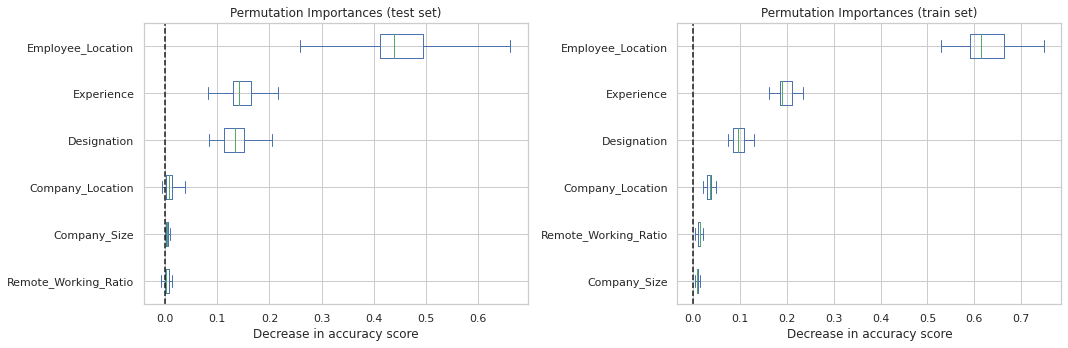

In [149]:
#calculate permutation importance for test data 
result_test = permutation_importance(
    model, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,2,figsize=(15,5))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()

In [154]:
X = df4.drop(columns=['Remote_Working_Ratio','Company_Size'])
X_train = df4_train.drop(columns=['Remote_Working_Ratio','Company_Size']).values
y_train = df4_train["Y"].values
X_test = df4_test.drop(columns=['Remote_Working_Ratio','Company_Size']).values
y_test = df4_test["Y"].values

In [155]:
#volvemos a seleccionar un modelo
random_search = model_selection.RandomizedSearchCV(model_base, param_distributions=param_dic, n_iter=10, scoring="r2").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model r2:", round(random_search.best_score_, 2))
model = random_search.best_estimator_

Best Model parameters: {'subsample': 1, 'n_estimators': 300, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 5, 'max_depth': 4, 'learning_rate': 0.03}
Best Model r2: 1.0



--- Kfold Validation ---
 r2 mean - base model: 1.0  --> best model: 1


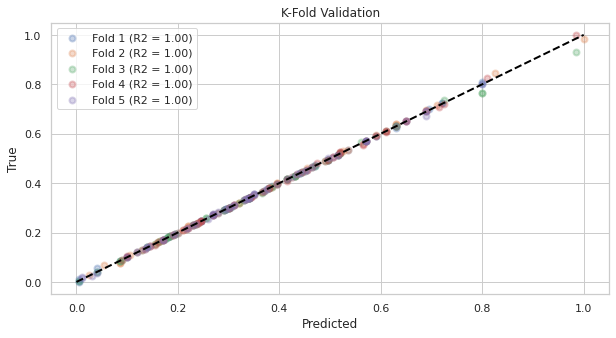

In [156]:
print("")
print("--- Kfold Validation ---")
Kfold_base = model_selection.cross_validate(estimator=model, X=X_train, y=y_train, cv=5, scoring="r2")
Kfold_model = model_selection.cross_validate(estimator=model_base, X=X_train, y=y_train, cv=5, scoring="r2")
print(" r2 mean - base model:", round(Kfold_base["test_score"].mean(),2), " --> best model:", round(Kfold_model["test_score"].mean()))

scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure(figsize=(10,5))
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train], y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

In [157]:
model.fit(X_train, y_train)
predicted = model.predict(X_test)

R2 (explained variance): 1.0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.0
Mean Absolute Error (Σ|y-pred|/n): 0.00
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.01
Max Error: 0.04


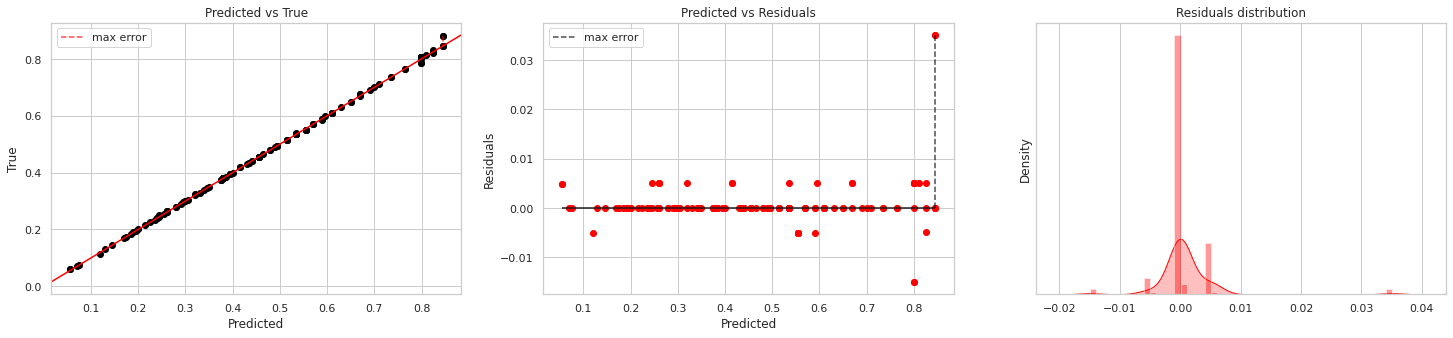

In [158]:
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:.2f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))

## residuals
residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:.2f}".format(max_error))

## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()

## Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()

## Plot residuals distribution
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax[2], label="mean = "+"{:,.0f}".format(np.mean(residuals)))
ax[2].grid(True)
ax[2].set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.show()